In [ ]:
from zipfile import ZipFile
file_name="OLD.zip"
with ZipFile (file_name,'r') as zip:
   zip.extractall()
   print('Done')

Done


In [ ]:
from zipfile import ZipFile
file_name="Train.zip"
with ZipFile (file_name,'r') as zip:
   zip.extractall()
   print('Done')

Done


In [ ]:
from zipfile import ZipFile
file_name="MIDDLE.zip"
with ZipFile (file_name,'r') as zip:
   zip.extractall()
   print('Done')

Done


In [ ]:
from zipfile import ZipFile
file_name="YOUNG.zip"
with ZipFile (file_name,'r') as zip:
   zip.extractall()
   print('Done')

Done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil, sys 
import keras as ks
from scipy.misc import *
from keras.layers import Dense, Input
from keras.optimizers import SGD,Adam
from keras.models import Model,Sequential
from shutil import copyfile, move
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,GlobalAveragePooling2D
from keras.layers import LeakyReLU,MaxPooling2D,Dropout
from keras.layers import BatchNormalization,Flatten
from keras.callbacks import TensorBoard as tensorbord1
from PIL import Image, ImageFile

In [ ]:
from keras.applications.resnet50 import ResNet50

In [ ]:
import os, sys
from PIL import Image

In [ ]:
# load data from dataset
train_csv = pd.read_csv("train.csv")
train_csv["Class"].unique()
train_csv.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [ ]:

for index, row in train_csv.iterrows():
    shutil.copy2("Train/"+row["ID"],row["Class"]+"/"+row["ID"])

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

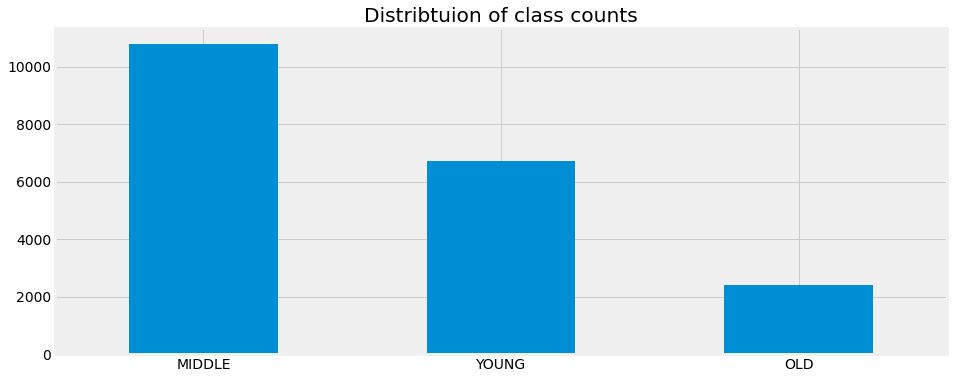

In [ ]:
#Representing existing 3 classes
plt.figure(figsize = (16,6))
plt.style.use("fivethirtyeight")
train_csv['Class'].value_counts(dropna = False).plot(kind = 'bar',grid = True)
plt.title("Distribtuion of class counts")
plt.xticks(rotation = 0)

In [ ]:
batch_size=52

# To handle image loading problem

#parameters of ImageDataGenerator:
#rescale: rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).
#shear_range: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
#zoom_range: Float or [lower, upper]. Range for random zoom.
#horizontal_flip: Boolean. Randomly flip inputs horizontally.

#parameters of flow_from_directory:
#directory: Directory where the data is located.
#target_size:(img_height, img_width).
#batch_size :size of the batches of data (default: 32).
#class_mode:one of( "binary", "categorical", "input", "multi_output", "raw", sparse")
#"binary": 1D numpy array of binary labels.
#"categorical": 2D numpy array of one-hot encoded labels. Supports multi-label output.
#"input": images identical to input images (mainly used to work with autoencoders).
#"multi_output": list with the values of the different columns.
#"raw": numpy array of values in y_col column(s).
#"sparse": 1D numpy array of integer labels.
#"None": no targets are returned (the generator will only yield batches of image data, which is useful to use in model.predict()).


ImageFile.LOAD_TRUNCATED_IMAGES = True
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training',
                                   target_size = (64, 64),
                                   batch_size = batch_size,
                                   class_mode = 'categorical')

validation_set = test_datagen.flow_from_directory('dataset/validation_set',
                                  target_size = (64, 64),
                                  batch_size = batch_size,
                                  class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('dataset/Test',
                                  target_size = (64, 64),
                                  batch_size = batch_size,
                                  class_mode = 'categorical')

print(training_set.class_indices)

Found 19906 images belonging to 3 classes.
Found 4158 images belonging to 3 classes.
{'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}


In [ ]:
#conv2D parameters:
#filters:The first required Conv2D parameter is the number of filters that the convolutional layer will learn.
#kernel_size:specifying the width and height of the 2D convolution window.
#The padding parameter of the Keras Conv2D class can take one of two values: ‘valid’ or ‘same’.
#Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.
#Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.


model = Sequential()
#two input layer
model.add(Conv2D(64, (3, 3),activation='relu', input_shape = (64, 64, 3),padding='same'))# 64x64 RGB images
model.add(Conv2D(32, (3, 3),activation='relu', input_shape = (64, 64, 3),padding='same'))
model.add(LeakyReLU(alpha=0.3))

#batch
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

# Dropout
model.add(Dropout(0.4))

#Max Pooling
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
#model.add(Activation('relu'))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization())

# Dropout
model.add(Dropout(0.3))

#Flatten
model.add(Flatten())
model.add(Dense(128,activation='relu'))
#model.add(Activation('relu'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(64))

#output layer
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 32)       

In [ ]:
# compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#fitting model
history = model.fit_generator(training_set,
                         steps_per_epoch = len(training_set),
                         epochs = 40,
                         validation_data = validation_set,
                         validation_steps = len(validation_set),
#                          callbacks=[tensorbord1],
                         verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
383/383 - 470s - loss: 1.0434 - accuracy: 0.5547 - val_loss: 0.7291 - val_accuracy: 0.7588
Epoch 2/40
383/383 - 471s - loss: 0.8662 - accuracy: 0.6108 - val_loss: 0.7354 - val_accuracy: 0.6758
Epoch 3/40
383/383 - 470s - loss: 0.8151 - accuracy: 0.6409 - val_loss: 0.7541 - val_accuracy: 0.6566
Epoch 4/40
383/383 - 473s - loss: 0.7664 - accuracy: 0.6674 - val_loss: 0.7062 - val_accuracy: 0.7006
Epoch 5/40
383/383 - 472s - loss: 0.7476 - accuracy: 0.6792 - val_loss: 0.5398 - val_accuracy: 0.7997
Epoch 6/40
383/383 - 471s - loss: 0.7343 - accuracy: 0.6803 - val_loss: 0.5177 - val_accuracy: 0.7977
Epoch 7/40
383/383 - 471s - loss: 0.7120 - accuracy: 0.6926 - val_loss: 0.6573 - val_accuracy: 0.6881
Epoch 8/40
383/383 - 469s - loss: 0.7015 - accuracy: 0.6979 - val_loss: 0.6768 - val_accuracy: 0.7044
Epoch 9/40
383/383 - 468s - loss: 0.6829 - accuracy: 0.7106 - val_loss: 0.6286 - val_accuracy: 0.7177
Epoch 10/40
383/383 - 469s - loss: 0.6685 - accuracy: 0.7191 - val_loss: 0.7239 - 

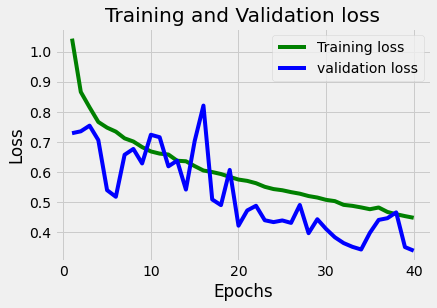

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

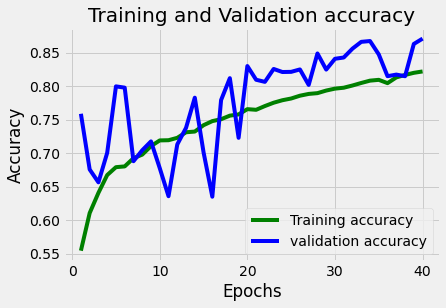

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()